![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/competitions/miad2024-12-prediccion-precio-vehiculos).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
import pandas as pd
import numpy as np

In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

In [4]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [5]:
# Visualización datos de test
dataTesting.head()

,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


#### Preprocesamiento del data set

In [27]:
dataTraining.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Price,400000.0,NaN,NaN,NaN,21146.919312,10753.66494,5001.0,13499.0,18450.0,26999.0,79999.0
Year,400000.0,NaN,NaN,NaN,2013.198125,3.292326,1997.0,2012.0,2014.0,2016.0,2018.0
Mileage,400000.0,NaN,NaN,NaN,55072.956895,40881.018845,5.0,25841.0,42955.0,77433.0,2457832.0
State,400000,51,TX,45918,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Make,400000,38,Ford,62899,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Model,400000,525,Silverado,18085,NaN,NaN,NaN,NaN,NaN,NaN,NaN


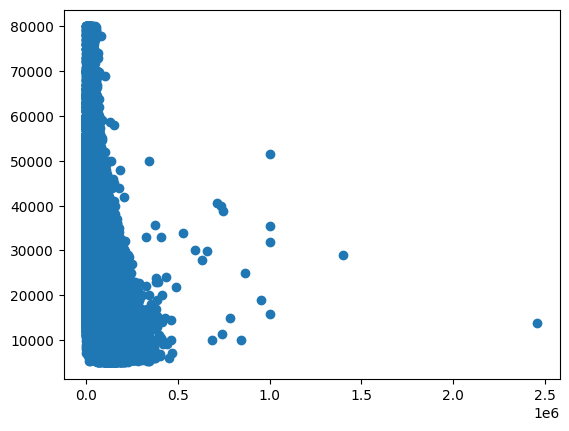

In [28]:
import matplotlib.pyplot as plt

plt.scatter(dataTraining['Mileage'], dataTraining['Price'])
plt.show()

In [26]:
# Separación de variables predictoras (X) y variable de interés (y)
y = dataTraining['Price']
Train = dataTraining.drop(['Price'], axis=1)

In [27]:
Train['dataset'] = 'Train'

In [28]:
Test = dataTesting.copy()
Test['dataset'] = 'Test'

In [29]:
df_complete = pd.concat([Train,Test])
df_complete

,Year,Mileage,State,Make,Model,dataset
0,2017,9913,FL,Jeep,Wrangler,Train
1,2015,20578,OH,Chevrolet,Tahoe4WD,Train
2,2012,83716,TX,BMW,X5AWD,Train
3,2014,28729,OH,Cadillac,SRXLuxury,Train
4,2013,64032,CO,Jeep,Wrangler,Train
...,...,...,...,...,...,...
99995,2015,82719,TX,GMC,Savana,Test
99996,2015,19711,UT,BMW,5,Test
99997,2016,48049,CA,Nissan,MuranoAWD,Test
99998,2017,15306,CO,Jeep,PatriotSport,Test


In [30]:
df_complete['State'] = df_complete['State'].str.upper()
df_complete['Model'] = df_complete['Model'].str.upper()
df_complete['Make'] = df_complete['Make'].str.upper()

In [31]:
StateCode = pd.factorize(df_complete['State'])[0]
df_state = pd.concat([pd.DataFrame(df_complete['State']).reset_index(drop=True),pd.DataFrame(StateCode,columns=['Code'])],axis=1)
df_state = df_state.drop_duplicates()
df_state.to_csv('model/df_state_code.csv',index=False)


ModelCode = pd.factorize(df_complete['Model'])[0]
df_model = pd.concat([pd.DataFrame(df_complete['Model']).reset_index(drop=True),pd.DataFrame(ModelCode,columns=['Code'])],axis=1)
df_model = df_model.drop_duplicates()
df_model.to_csv('model/df_model_code.csv',index=False)


MakeCode = pd.factorize(df_complete['Make'])[0]
df_make = pd.concat([pd.DataFrame(df_complete['Make']).reset_index(drop=True),pd.DataFrame(MakeCode,columns=['Code'])],axis=1)
df_make = df_make.drop_duplicates()
df_make.to_csv('model/df_make_code.csv',index=False)


In [32]:
# Codificación de las variables categoricas, se codifican todos los dataset para
# asegurar la misma codificación
df_complete['State'] = pd.factorize(df_complete.State)[0]
df_complete['Make'] = pd.factorize(df_complete.Make)[0]
df_complete['Model'] = pd.factorize(df_complete.Model)[0]

In [33]:
X = df_complete[df_complete['dataset'] == 'Train']
X_test_final = df_complete[df_complete['dataset'] == 'Test']

In [34]:
X = X.drop(['dataset'], axis=1)
X_test_final = X_test_final.drop(['dataset'], axis=1)

In [35]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

##### Opción adicional preprocesamiento

In [182]:
# Estandarizar la variable Mileage en los sets de entrenamiento y testeo
from sklearn.preprocessing import StandardScaler

In [190]:
# Inicializar el StandardScaler
scaler = StandardScaler(with_mean = True)

# Escalonar los valores de la variable Mileage en los sets de entrenamiento y testeo
scaler.fit(X[['Mileage']])
mileage_scaler_train = scaler.transform(X[['Mileage']])

In [192]:
mileage_scaler_test = scaler.transform(X_test_final[['Mileage']])

In [194]:
X['Mileage_escalonado'] = mileage_scaler_train

In [198]:
X_test_final['Mileage_escalonado'] = mileage_scaler_test

In [200]:
X = X.drop(['Mileage'], axis=1)
X_test_final = X_test_final.drop(['Mileage'], axis=1)

In [204]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.33, random_state=2)

#### Modelos para regresión

##### Modelo Random Forest

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [37]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 3, n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=3)

In [38]:
y_pred = rf.predict(X_test)
rmse_scores = (np.sqrt(mean_squared_error(y_test, y_pred)))

In [39]:
rmse_scores

3779.7395556247966

In [40]:
# Calibración sobre n_estimators
estimator_range = range(400, 710, 50)

# Lista para almacenar el valor de RMSE para cada valor de número de árboles en el modelo
rmse_scores = []

for estimator in estimator_range:
    rf = RandomForestRegressor(n_estimators = estimator, random_state = 3, n_jobs = -1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

Text(0, 0.5, 'rmse')

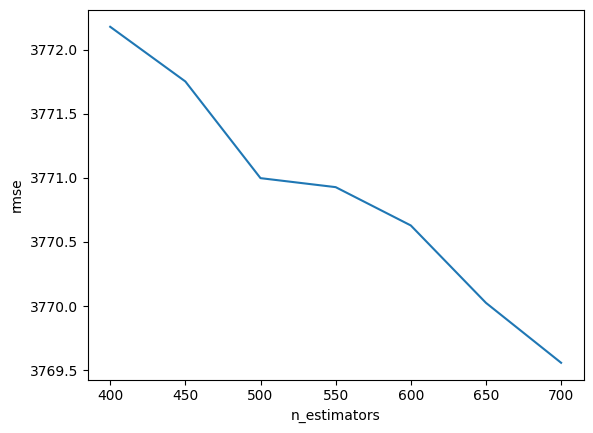

In [43]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
import matplotlib.pyplot as plt

plt.plot(estimator_range, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('rmse')

In [44]:
best_n_estimators = estimator_range[rmse_scores.index(min(rmse_scores))]
best_n_estimators, min(rmse_scores)

(700, 3769.557198384785)

In [33]:
# Calibración max_features
feature_range = range(1, X_train.shape[1]+1)

# Lista para almacenar el valor de RMSE para cada valor max features
rmse_scores = []

for feature in feature_range:
    rf = RandomForestRegressor(n_estimators = best_n_estimators, max_features=feature, random_state = 3, n_jobs = -1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

Text(0, 0.5, 'rmse')

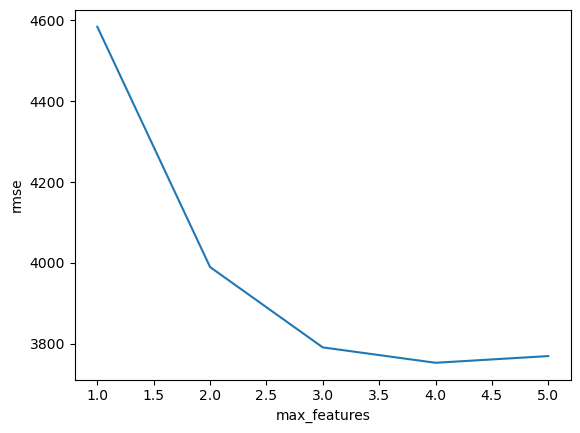

In [34]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, rmse_scores)
plt.xlabel('max_features')
plt.ylabel('rmse')

In [35]:
best_n_features = feature_range[rmse_scores.index(min(rmse_scores))]
best_n_features, min(rmse_scores)

(4, 3752.9915178698516)

In [27]:
# Calibración max_depth

depth_range = range(15, 26)

# Lista para almacenar el valor de RMSE para cada valor de max_depth
rmse_scores = []

for depth in depth_range:
    rf = RandomForestRegressor(n_estimators = best_n_estimators, max_features=4, max_depth = depth, random_state = 3, n_jobs = -1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

Text(0, 0.5, 'rmse')

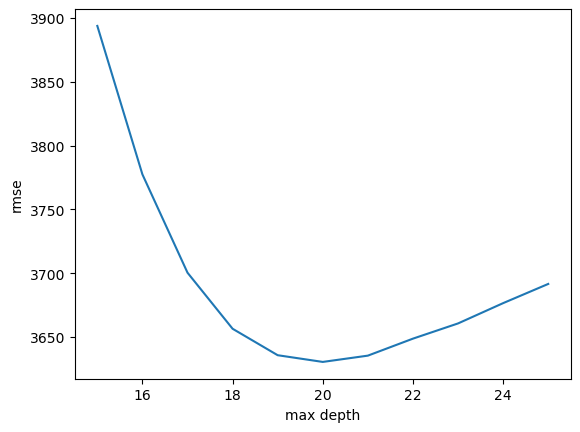

In [28]:
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, rmse_scores)
plt.xlabel('max depth')
plt.ylabel('rmse')

In [29]:
best_depth = depth_range[rmse_scores.index(min(rmse_scores))]
best_depth, min(rmse_scores)

(20, 3630.510860482024)

In [36]:
rf = RandomForestRegressor(n_estimators = best_n_estimators, max_features=best_n_features, max_depth = best_depth, random_state = 3, n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features=4, n_estimators=700, n_jobs=-1,
                      random_state=3)

In [37]:
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [38]:
rmse

3630.510860482024

#### Entrenar el modelo con toda la data de Train disponible

In [39]:
rf_final = RandomForestRegressor(n_estimators = best_n_estimators, max_features=best_n_features, max_depth = best_depth, random_state = 3, n_jobs = -1)
rf_final.fit(X, y)

RandomForestRegressor(max_depth=20, max_features=4, n_estimators=700, n_jobs=-1,
                      random_state=3)

In [40]:
y_pred_test = rf_final.predict(X_test_final)

In [41]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
y_pred_test1 = pd.DataFrame(y_pred_test, index=X_test_final.index, columns=['Price'])

In [42]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred_test1.to_csv('./test_submission_5_ldgl.csv', index_label='ID')

#### Entrenar un modelo XGBoost

In [148]:
from xgboost import XGBRegressor

In [212]:
# Se inicializa el objeto de clase XGBRegressor con los parámetros por defecto
rgr = XGBRegressor()

# Se entrena el modelo con parámetros por defecto
rgr.fit(X_train2, y_train2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [213]:
#Se calculan las predicciones usando la base de test
y_pred_xgb = rgr.predict(X_test2)
# Cálculo de las métricas de evaluación del modelo
rmse_xgb = np.sqrt(mean_squared_error(y_test2, y_pred_xgb))
rmse_xgb

3995.4947958723947

In [214]:
# Calibración sobre n_estimators
estimator_range = range(200, 710, 10)
# Lista para almacenar el valor de RMSE para cada valor de gamma
rmse_scores = []

for estimator in estimator_range:
    rgr = XGBRegressor(random_state = 3, n_estimators = estimator)
    rgr.fit(X_train2, y_train2)

    y_pred = rgr.predict(X_test2)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test2, y_pred)))

Text(0, 0.5, 'RMSE')

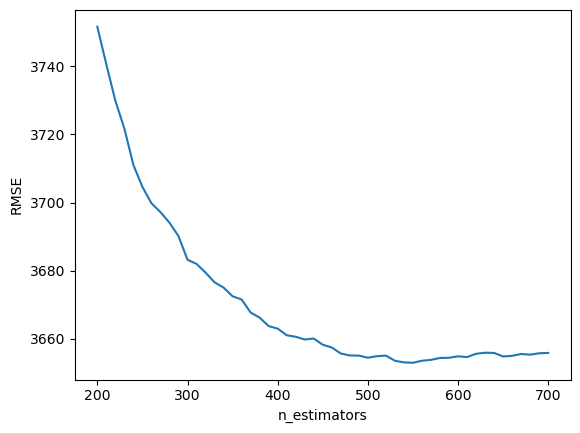

In [215]:
# Gráfica del desempeño del modelo vs valor del parámetro learning_rate (eta)
plt.plot(estimator_range, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

In [217]:
best_n_estimators_xgb = estimator_range[rmse_scores.index(min(rmse_scores))]
best_n_estimators_xgb, min(rmse_scores)

(550, 3652.9323812858206)

In [218]:
# Calibración max_depth
depth_range = range(1, 15)

# Lista para almacenar el valor de RMSE para cada valor de max_depth
rmse_scores = []

for depth in depth_range:
    rgr = XGBRegressor(random_state = 3, n_estimators = best_n_estimators_xgb, max_depth = depth)
    rgr.fit(X_train2, y_train2)

    y_pred = rgr.predict(X_test2)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test2, y_pred)))

Text(0, 0.5, 'rmse')

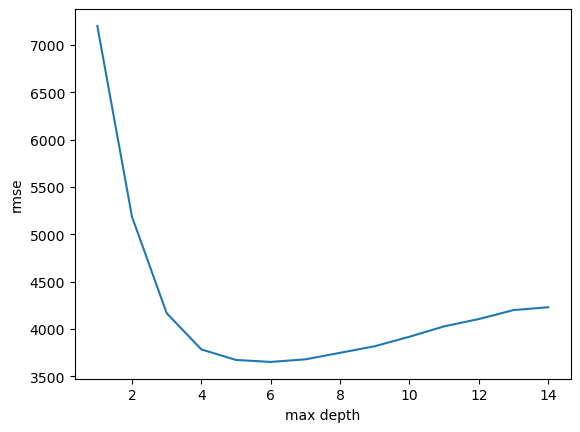

In [219]:
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, rmse_scores)
plt.xlabel('max depth')
plt.ylabel('rmse')

In [220]:
best_depth = depth_range[rmse_scores.index(min(rmse_scores))]
best_depth, min(rmse_scores)

(6, 3652.9323812858206)

In [221]:
# Calibración del parámetro learning rate
eta_range = np.arange(0.01, 0.5, 0.02) #Por defecto es 0.3

# Lista para almacenar el valor de RMSE para cada valor de learning rate
rmse_scores = []

for eta_val in eta_range:
    rgr = XGBRegressor(random_state = 3, n_estimators = best_n_estimators_xgb, max_depth = best_depth, eta = eta_val)
    rgr.fit(X_train2, y_train2)

    y_pred = rgr.predict(X_test2)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test2, y_pred)))

Text(0, 0.5, 'RMSE')

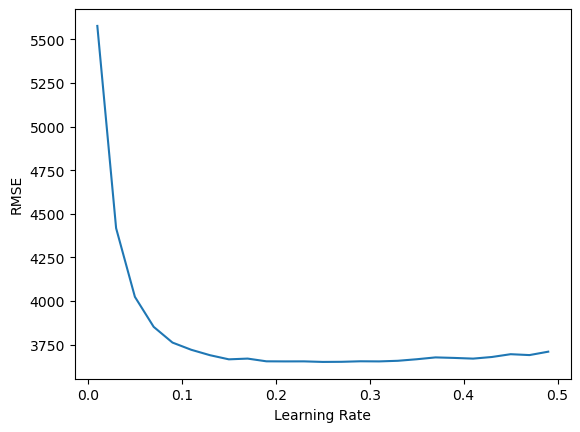

In [222]:
# Gráfica del desempeño del modelo vs valor del parámetro learning_rate (eta)
plt.plot(eta_range, rmse_scores)
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')

In [223]:
best_eta = eta_range[rmse_scores.index(min(rmse_scores))]
best_eta, min(rmse_scores)

(0.24999999999999997, 3651.1166891225985)

In [172]:
# Calibración del parámetro gamma
gamma_range = range(0, 300, 5)

# Lista para almacenar el valor de RMSE para cada valor de gamma
rmse_scores = []

for gamma_val in gamma_range:
    rgr = XGBRegressor(random_state = 3, gamma = gamma_val, n_estimators = best_n_estimators_xgb, max_depth = best_depth, eta = best_eta)
    rgr.fit(X_train, y_train)

    y_pred = rgr.predict(X_test)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

Text(0, 0.5, 'RMSE')

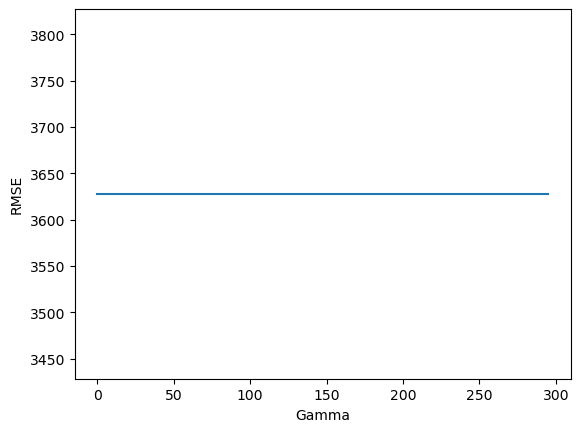

In [173]:
# Gráfica del desempeño del modelo vs valor del parámetro learning_rate (eta)
plt.plot(gamma_range, rmse_scores)
plt.xlabel('Gamma')
plt.ylabel('RMSE')

In [229]:
rgr = XGBRegressor(random_state = 3, n_estimators = 570, max_depth = 6, eta = 0.24999999999999997)
rgr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.24999999999999997,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=570,
             n_jobs=None, num_parallel_tree=None, ...)

In [232]:
y_pred = rgr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

3627.8164782243066

##### 2. Modelo Entrenar el mejor modelo con toda la data de Train disponible

In [211]:
# Mejores parametros: (570, 6, 0.24999999999999997)
best_n_estimators_xgb, best_depth, best_eta

(570, 6, 0.24999999999999997)

In [176]:
rf_final = XGBRegressor(random_state = 3, n_estimators = best_n_estimators_xgb, max_depth = best_depth, eta = best_eta)
rf_final.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.24999999999999997,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=570,
             n_jobs=None, num_parallel_tree=None, ...)

In [177]:
y_pred_test = rf_final.predict(X_test_final)

In [178]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
y_pred_test1 = pd.DataFrame(y_pred_test, index=X_test_final.index, columns=['Price'])

In [180]:
y_pred_test1.head()

,Price
0,20905.466797
1,37031.261719
2,22166.496094
3,7811.519531
4,31074.292969


In [181]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred_test1.to_csv('./test_submission_3_ldgl.csv', index_label='ID')